In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

sys.path.append(os.path.abspath(os.path.join('..')))

from src.utils import (
    load_data, 
    clean_dataset, 
    process_budget_revenue, 
    feature_engineering_pipeline,
    prepare_features_for_ml
)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:

raw_data_path = '../data/original/TMDB_movie_dataset.csv'
output_dir = '../data/cleaned'
output_path = os.path.join(output_dir, 'TMDB_movie_dataset_cleaned.csv')

df = load_data(raw_data_path)
print(f"Original rows: {df.shape[0]}")

df = clean_dataset(df)

df = process_budget_revenue(df)

df = feature_engineering_pipeline(df)

print(f"Rows after filtering and processing: {df.shape[0]}")

df = prepare_features_for_ml(df)

df.to_csv(output_path, index=False)




Original rows: 1331729
Rows after filtering and processing: 7775


Top 10 companies
Warner Bros. Pictures    587
Universal Pictures       573
Paramount                461
20th Century Fox         460
Columbia Pictures        443
Metro-Goldwyn-Mayer      277
New Line Cinema          228
Walt Disney Pictures     192
Canal+                   177
Touchstone Pictures      159
Name: count, dtype: int64


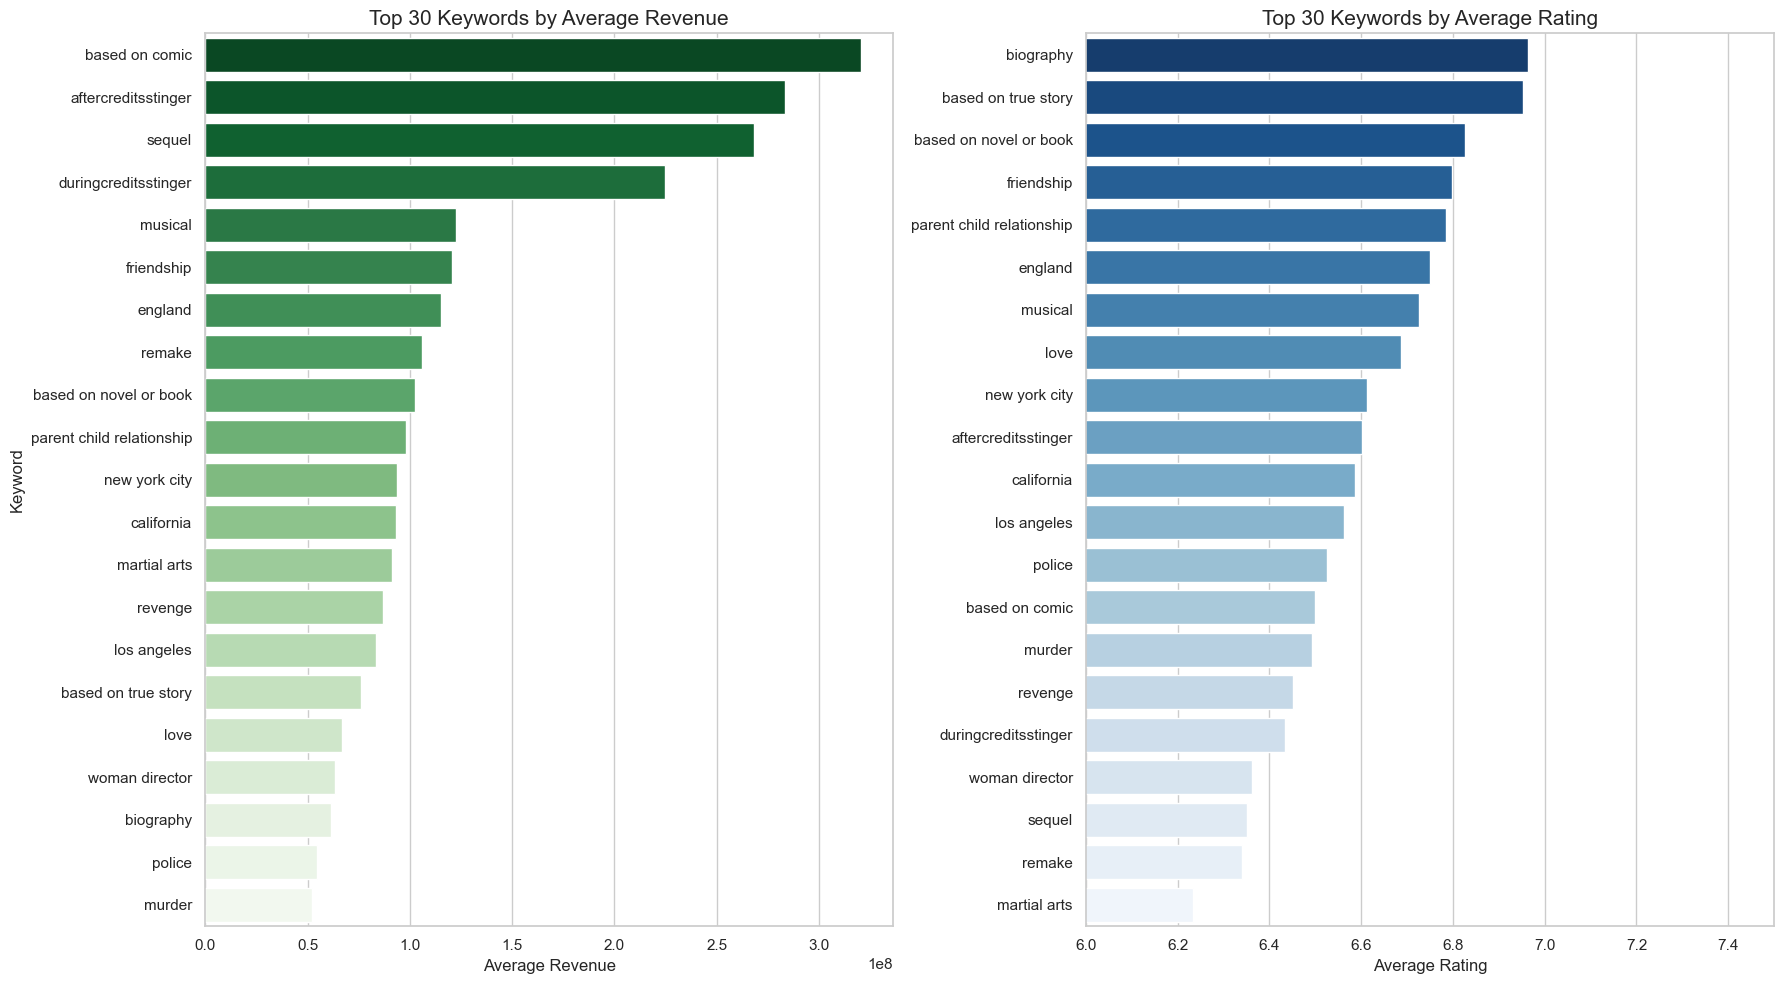

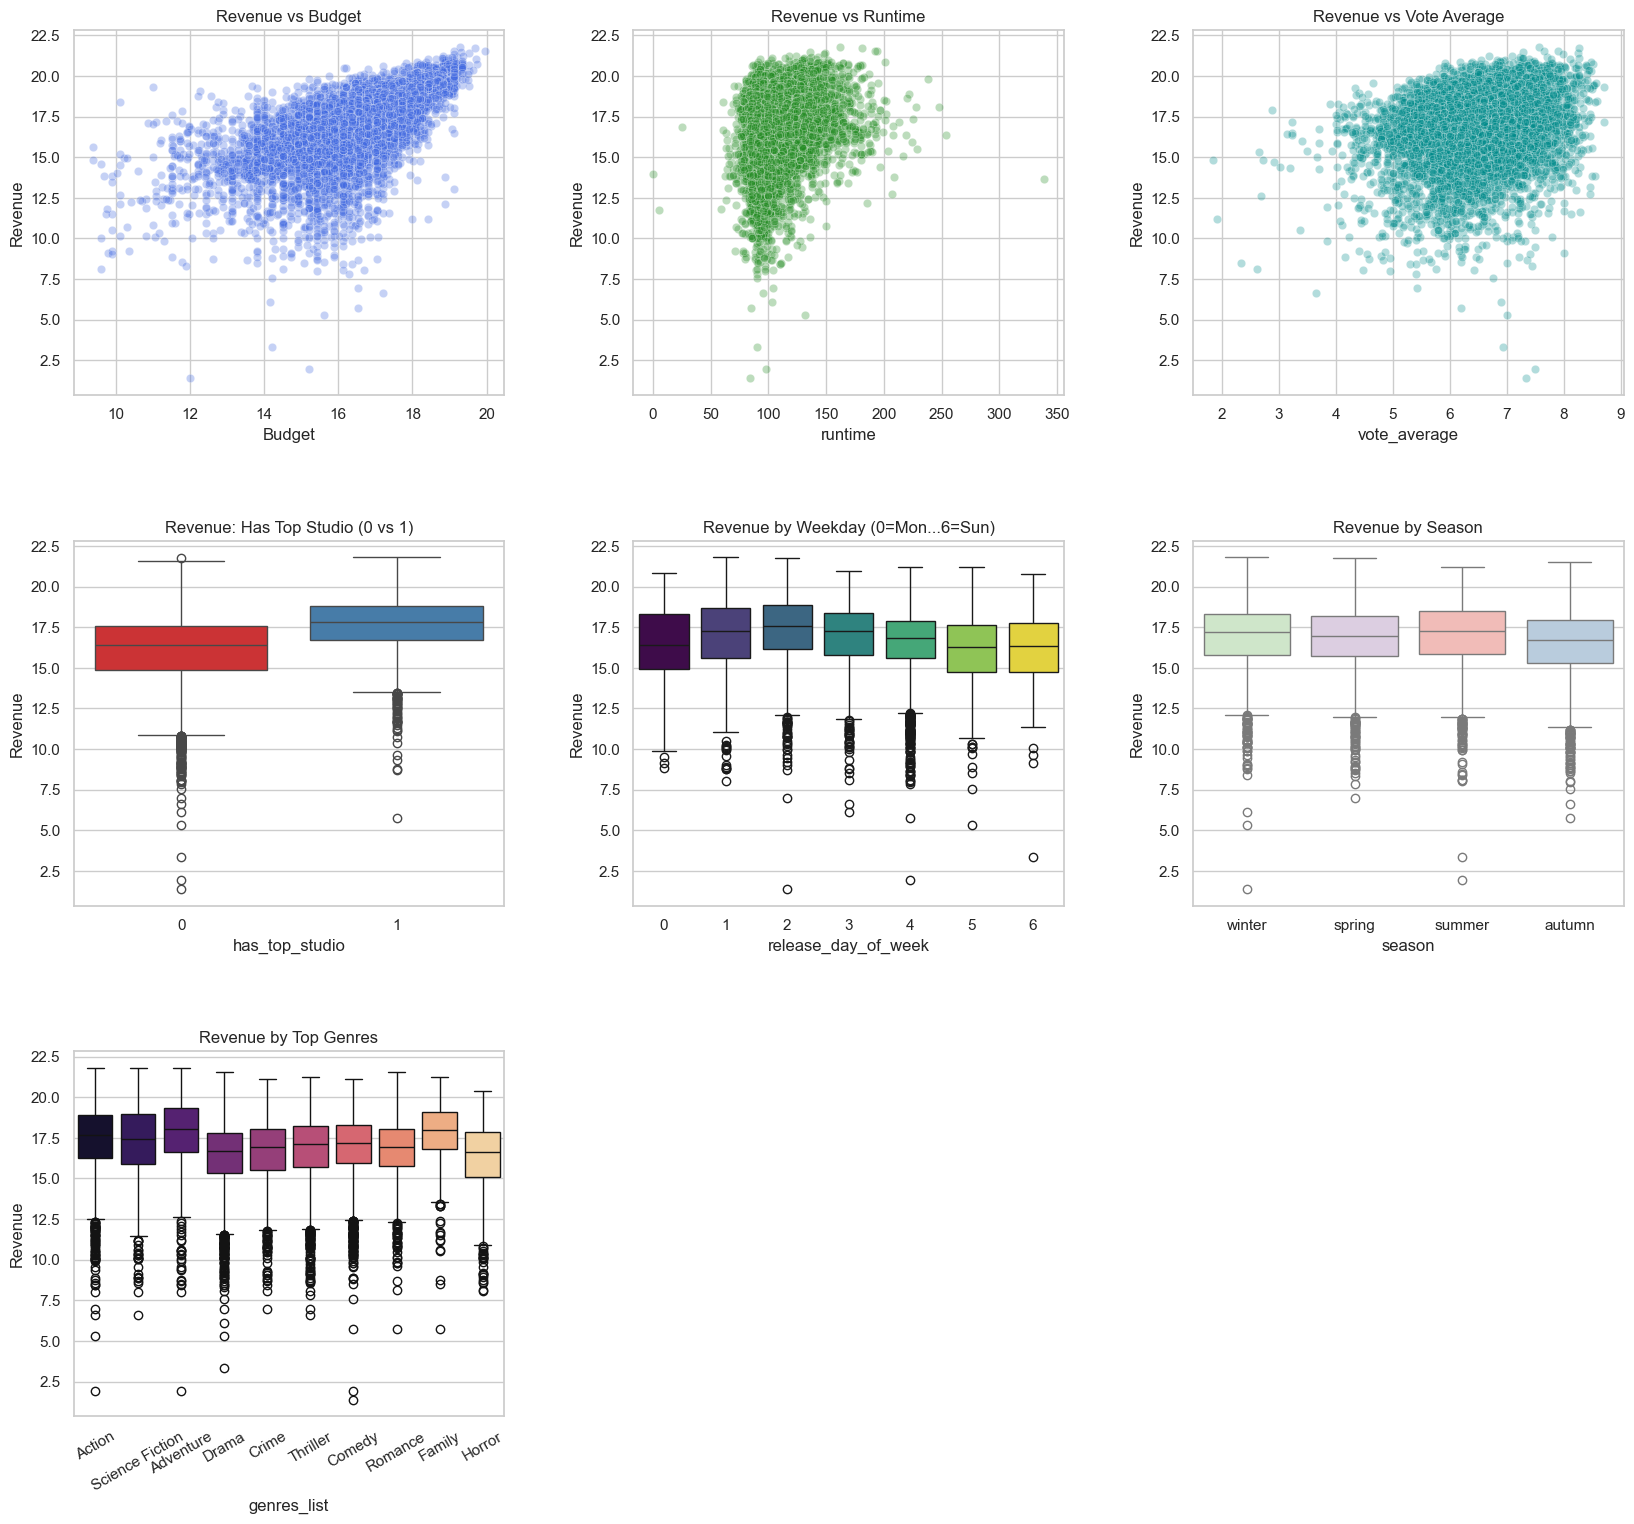

In [26]:
all_companies = [c for sublist in df['production_companies_list'] for c in sublist]
top_10_companies = pd.Series(all_companies).value_counts().head(10)
print("Top 10 companies")
print(top_10_companies)

# Collect all keywords
all_keywords = [k for sublist in df['keywords_list'] for k in sublist]

# Top 100 most frequent keywords
keyword_counts = Counter(all_keywords)
common_keywords = [k for k, v in keyword_counts.most_common(200)]

keyword_stats = []

for k in common_keywords:
    mask = df['keywords_list'].apply(lambda x: k in x)
    subset = df[mask]
    
    if len(subset) >= 200:
        stats = {
            'keyword': k,
            'count': len(subset),
            'mean_revenue': subset['revenue'].mean(),
            'median_revenue': subset['revenue'].median(),
            'mean_vote': subset['vote_average'].mean(),
            'mean_budget': subset['budget'].mean()
        }
        keyword_stats.append(stats)

stats_df = pd.DataFrame(keyword_stats)

# Top 15 by Revenue and Rating
top_revenue_keywords = stats_df.sort_values(by='mean_revenue', ascending=False).head(30)
top_rated_keywords = stats_df.sort_values(by='mean_vote', ascending=False).head(30)

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Plot 1: Revenue
sns.barplot(
    x='mean_revenue', y='keyword', data=top_revenue_keywords, 
    palette='Greens_r', hue='keyword', legend=False, ax=axes[0]
)
axes[0].set_title('Top 30 Keywords by Average Revenue', fontsize=15)
axes[0].set_xlabel('Average Revenue', fontsize=12)
axes[0].set_ylabel('Keyword', fontsize=12)

# Plot 2: Rating
sns.barplot(
    x='mean_vote', y='keyword', data=top_rated_keywords, 
    palette='Blues_r', hue='keyword', legend=False, ax=axes[1]
)
axes[1].set_title('Top 30 Keywords by Average Rating', fontsize=15)
axes[1].set_xlabel('Average Rating', fontsize=12)
axes[1].set_ylabel('')
axes[1].set_xlim(6.0, 7.5) 

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(3, 3, figsize=(20, 18))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Revenue vs Budget 
sns.scatterplot(x='log_budget', y='log_revenue', data=df, alpha=0.3, color='royalblue', ax=axes[0, 0])
axes[0, 0].set_title('Revenue vs Budget')
axes[0, 0].set_xlabel('Budget')
axes[0, 0].set_ylabel('Revenue')

# Revenue vs Runtime
sns.scatterplot(x='runtime', y='log_revenue', data=df, alpha=0.3, color='forestgreen', ax=axes[0, 1])
axes[0, 1].set_title('Revenue vs Runtime')
axes[0, 1].set_ylabel('Revenue')

# Revenue vs Vote Average
sns.scatterplot(x='vote_average', y='log_revenue', data=df, alpha=0.3, color='darkcyan', ax=axes[0, 2])
axes[0, 2].set_title('Revenue vs Vote Average')
axes[0, 2].set_ylabel('Revenue')

# Revenue vs Has Top Studio
sns.boxplot(
    x='has_top_studio', y='log_revenue', data=df, 
    palette='Set1', hue='has_top_studio', legend=False, ax=axes[1, 0]
)
axes[1, 0].set_title('Revenue: Has Top Studio (0 vs 1)')
axes[1, 0].set_ylabel('Revenue')

# Revenue by Weekday
sns.boxplot(
    x='release_day_of_week', y='log_revenue', data=df, 
    palette='viridis', hue='release_day_of_week', legend=False, ax=axes[1, 1]
)
axes[1, 1].set_title('Revenue by Weekday (0=Mon...6=Sun)')
axes[1, 1].set_ylabel('Revenue')

# Revenue by Season
season_order = ['winter', 'spring', 'summer', 'autumn']
sns.boxplot(
    x='season', y='log_revenue', data=df, order=season_order, 
    palette='Pastel1', hue='season', legend=False, ax=axes[1, 2]
)
axes[1, 2].set_title('Revenue by Season')
axes[1, 2].set_ylabel('Revenue')

# Revenue by Genres 
df_exploded = df.explode('genres_list')
top_genres = df_exploded['genres_list'].value_counts().head(10).index
df_genres_top = df_exploded[df_exploded['genres_list'].isin(top_genres)]

sns.boxplot(
    x='genres_list', y='log_revenue', data=df_genres_top, 
    palette='magma', hue='genres_list', legend=False, ax=axes[2, 0]
)
axes[2, 0].tick_params(axis='x', rotation=30)
axes[2, 0].set_title('Revenue by Top Genres')
axes[2, 0].set_ylabel('Revenue')

# Remove empty plots in the last row
fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

plt.show()

Training Data Shape: (6220, 39)
Linear Regression    -> R2: 0.5221 | RMSE: 1.4455
Random Forest        -> R2: 0.5545 | RMSE: 1.3957
Gradient Boosting    -> R2: 0.5652 | RMSE: 1.3788


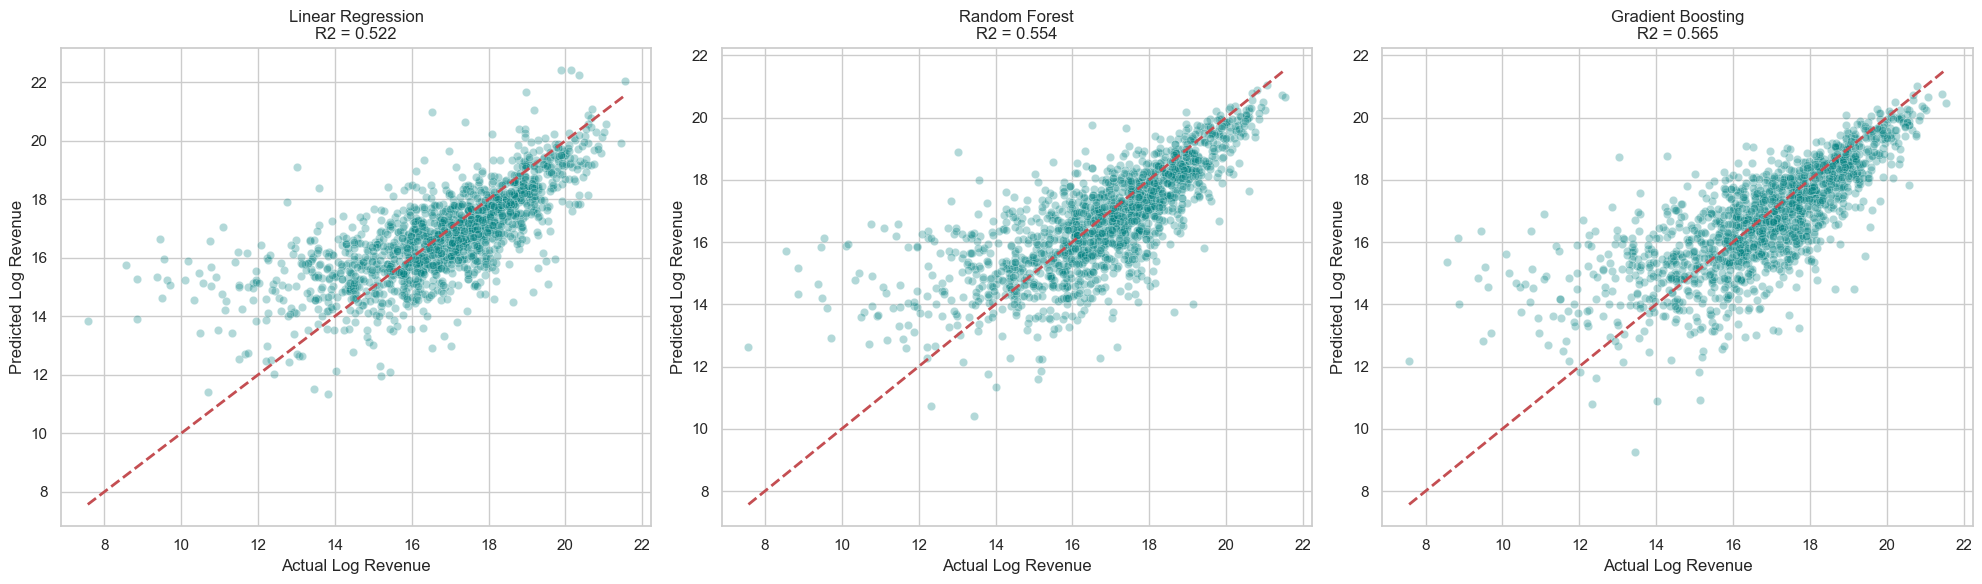

Revenue Classes Distribution:
revenue_class
Below Avg      1949
Flop/Low       1944
Blockbuster    1944
Above Avg      1938
Name: count, dtype: int64

Classification Accuracy: 55.95%

Classification Report:
               precision    recall  f1-score   support

   Above Avg       0.44      0.47      0.45       387
   Below Avg       0.45      0.39      0.41       390
 Blockbuster       0.73      0.72      0.73       389
    Flop/Low       0.61      0.66      0.64       389

    accuracy                           0.56      1555
   macro avg       0.56      0.56      0.56      1555
weighted avg       0.56      0.56      0.56      1555



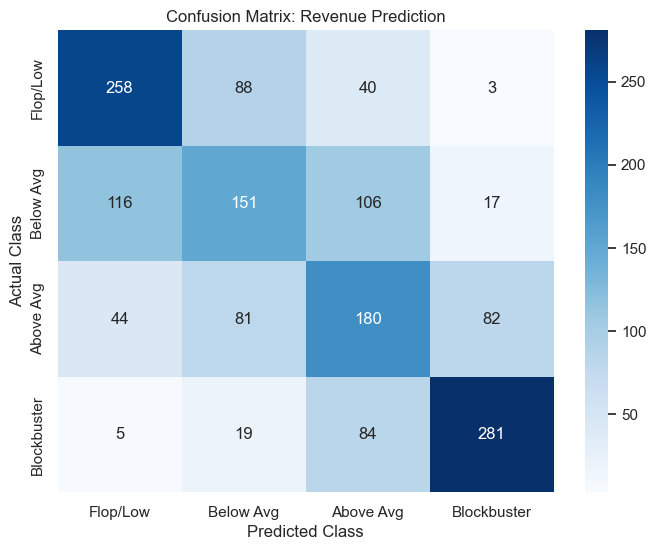

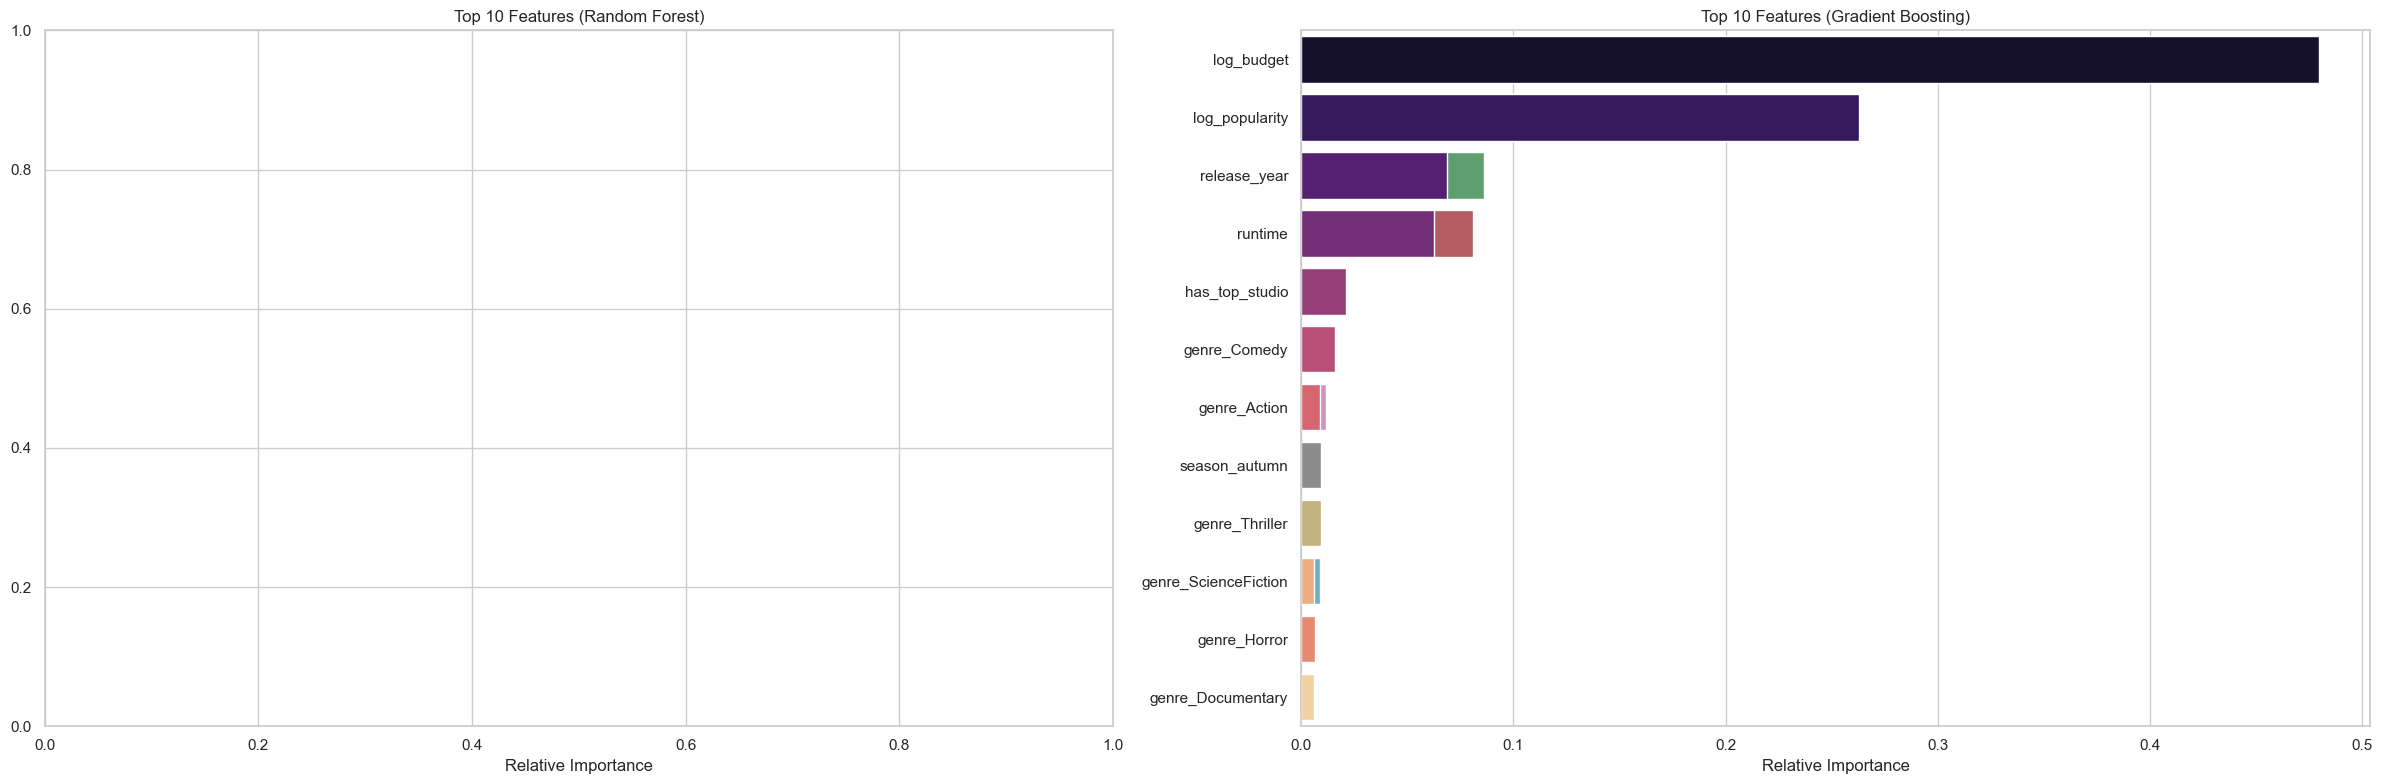

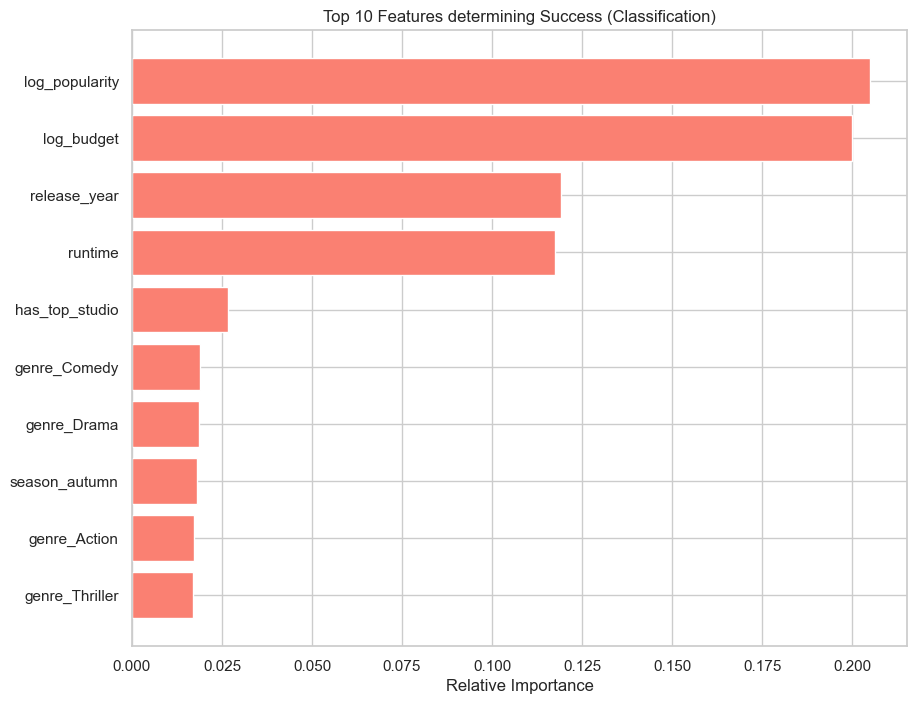

In [ ]:

feature_cols = [
    'log_budget', 'log_popularity', 'release_year', 'runtime', 
    'has_top_studio', 'is_weekend'
]
# Add One-Hot columns
feature_cols += [c for c in df.columns if c.startswith('genre_')]
feature_cols += [c for c in df.columns if c.startswith('season_')]
feature_cols += [c for c in df.columns if c.startswith('studio_')]

# Clean NaNs
df_ml = df.dropna(subset=feature_cols + ['log_revenue', 'revenue'])

X = df_ml[feature_cols]
y_reg = df_ml['log_revenue']  # Our target

# Split Data
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Scale for Linear Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training Data Shape: {X_train.shape}")


models_reg = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
}

results_reg = {}

for name, model in models_reg.items():
    
    if name == "Linear Regression":
        model.fit(X_train_scaled, y_train_reg)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train_reg)
        preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
    r2 = r2_score(y_test_reg, preds)
    results_reg[name] = {'R2': r2, 'RMSE': rmse, 'Preds': preds}
    print(f"{name:20} -> R2: {r2:.4f} | RMSE: {rmse:.4f}")

# Plot Regression Results
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (name, res) in enumerate(results_reg.items()):
    ax = axes[i]
    sns.scatterplot(x=y_test_reg, y=res['Preds'], alpha=0.3, ax=ax, color='teal')
    # Ideal line
    min_val, max_val = y_test_reg.min(), y_test_reg.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax.set_title(f"{name}\nR2 = {res['R2']:.3f}")
    ax.set_xlabel("Actual Log Revenue")
    ax.set_ylabel("Predicted Log Revenue")

plt.tight_layout()
plt.show()


# 1. Create Classes for Revenue
# We split revenue into 4 quartiles: Flop, Low, Medium, High
df_ml['revenue_class'] = pd.qcut(df_ml['revenue'], q=4, labels=['Flop/Low', 'Below Avg', 'Above Avg', 'Blockbuster'])

print("Revenue Classes Distribution:")
print(df_ml['revenue_class'].value_counts())

y_class = df_ml['revenue_class']

# Split for Classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

# 2. Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train_c, y_train_c)
y_pred_c = clf.predict(X_test_c)

# 3. Evaluate
acc = accuracy_score(y_test_c, y_pred_c)
print(f"\nClassification Accuracy: {acc:.2%}")
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_c))

# 4. Confusion Matrix Plot
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_c, y_pred_c, labels=['Flop/Low', 'Below Avg', 'Above Avg', 'Blockbuster'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Flop/Low', 'Below Avg', 'Above Avg', 'Blockbuster'],
            yticklabels=['Flop/Low', 'Below Avg', 'Above Avg', 'Blockbuster'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix: Revenue Prediction')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# Random Forest Importance
rf_model = models_reg['Random Forest']
importances_rf = rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1][:10]
y_labels_rf = [X.columns[i] for i in indices_rf]
sns.barplot(x=importances_rf[indices_rf], y=y_labels_rf, hue=y_labels_rf, ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('Top 10 Features (Random Forest)')
axes[0].set_xlabel('Relative Importance')

# Gradient Boosting Importance
gb_model = models_reg['Gradient Boosting']
importances_gb = gb_model.feature_importances_
indices_gb = np.argsort(importances_gb)[::-1][:10]
y_labels_gb = [X.columns[i] for i in indices_gb]
sns.barplot(x=importances_gb[indices_gb], y=y_labels_gb, hue=y_labels_gb, ax=axes[1], palette='magma', legend=False)
axes[1].set_title('Top 10 Features (Gradient Boosting)')
axes[1].set_xlabel('Relative Importance')

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 8))
plt.title("Top 10 Features determining Success (Classification)")
plt.barh(range(10), importances[indices], align="center", color='salmon')
plt.yticks(range(10), [X.columns[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.show()

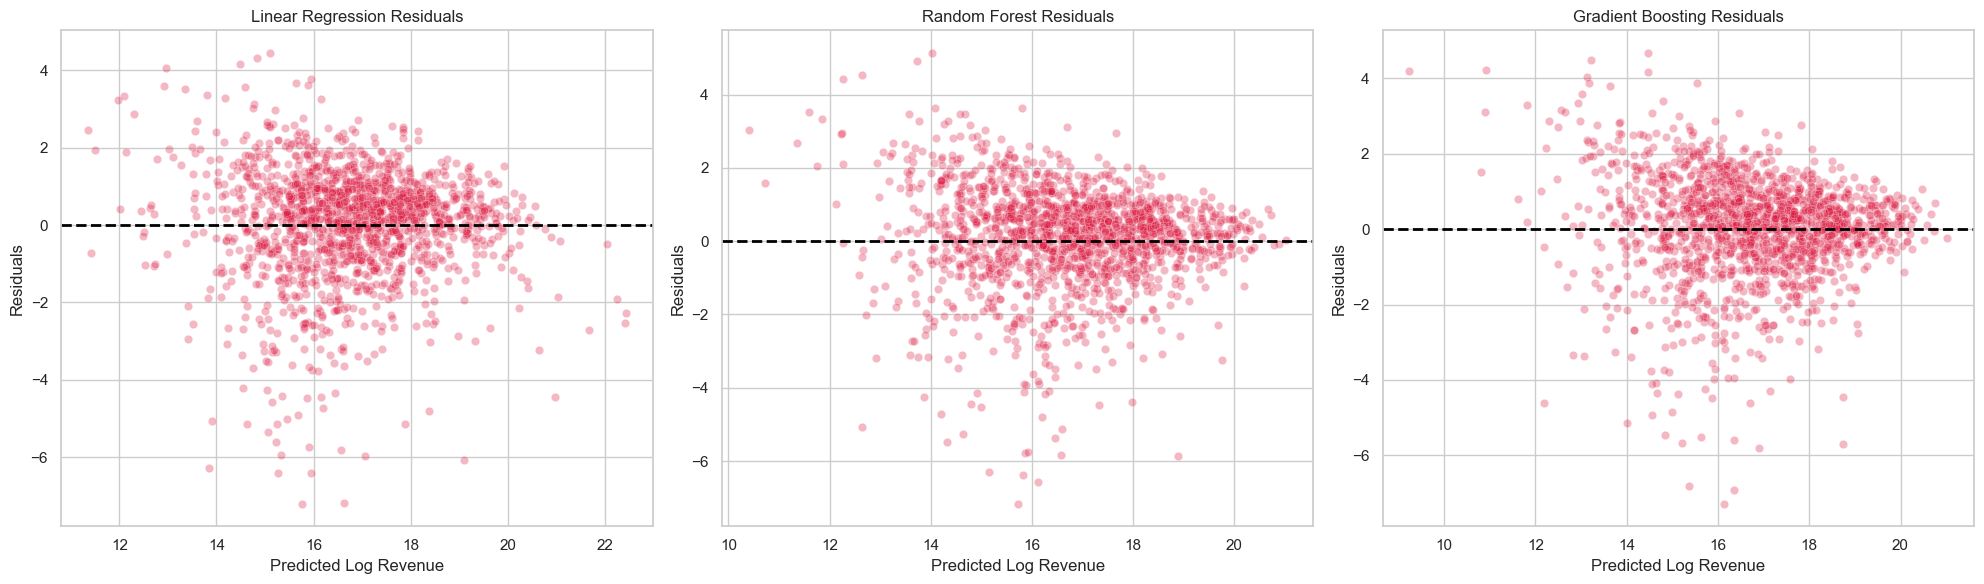

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (name, res) in enumerate(results_reg.items()):
    ax = axes[i]
    y_pred = res['Preds']
    y_true = y_test_reg
    
    residuals = y_true - y_pred
    
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.3, ax=ax, color='crimson')
    
    ax.axhline(0, color='black', linestyle='--', lw=2)
    
    ax.set_title(f"{name} Residuals")
    ax.set_xlabel("Predicted Log Revenue")
    ax.set_ylabel("Residuals")

plt.tight_layout()
plt.show()